# Project Statement

## Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log
returns of a stock/index are normally distributed.

Investigate if the log returns of stocks or indexes of your choosing are
normally distributed. Some suggestions for exploration include:

1.  Test if there are period of times when the log-returns of a
    stock/index have evidence of normal distribution.
2.  Test if removing extremal return data creates a distribution with
    evidence of being normal.
3.  Create a personalized portfolio of stocks with historical log return
    data that is normally distributed.
4.  Test if the portfolio you created in the first mini-project has
    significant periods of time with evidence of normally distributed
    log returns.
5.  Gather x-number of historical stock data and just perform a
    normality test on their log return data to see if any of the stocks
    exhibit evidence of log returns that are normally distributed.

# Data Retrieval

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")


Because of its high data availability, we choose the S&P 500 to analyze
for our index.

In [ ]:
def csv_to_series(csv_path):
    s = pd.read_csv(csv_path)
    s["Date"] = pd.to_datetime(s["Date"])
    s.set_index("Date",inplace = True)
    returns = (s.shift(-1)-s) / s
    returns.columns = [ticker + " Returns" for ticker in s.columns]
    return pd.concat([s, returns],axis=1)

sp500 = csv_to_series("./SP500-returns.csv")
sp500.rename(columns= {"SPYSIM": "SP500", "SPYSIM Returns":"SP500 Returns"},inplace=True)
log_returns = np.log((1+sp500["SP500 Returns"]).dropna())


# Heuristic Checks for Normality

As a preliminary look, we can look at the distribution of daily returns.

In [ ]:
log_returns.plot(kind="hist",
                          bins = 100,
                          xlabel="Logdaily Returns",
                          ylabel="Observations",
                          title="Distribution of Logdaily S&P 500 Returns")


``` example
<Axes: title={'center': 'Distribution of Logdaily S&P 500 Returns'}, xlabel='Logdaily Returns', ylabel='Observations'>
```

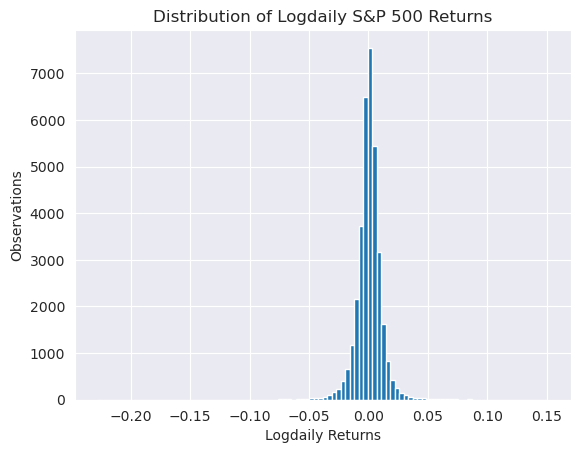

A visual inspection is far from sufficient for a test of normality. We
can first "zoom in" to the zero point to viseually cut out the outliers
of log returns of absolute magnitude $> 0.10$.

In [ ]:
log_returns.plot(kind="hist",
                          bins = 100,
                          xlabel="Log Returns",
                          ylabel="Observations",
                          xlim=(-.1,.1),
                          title="Distribution of Logdaily S&P 500 Returns")


``` example
<Axes: title={'center': 'Distribution of Logdaily S&P 500 Returns'}, xlabel='Log Returns', ylabel='Observations'>
```

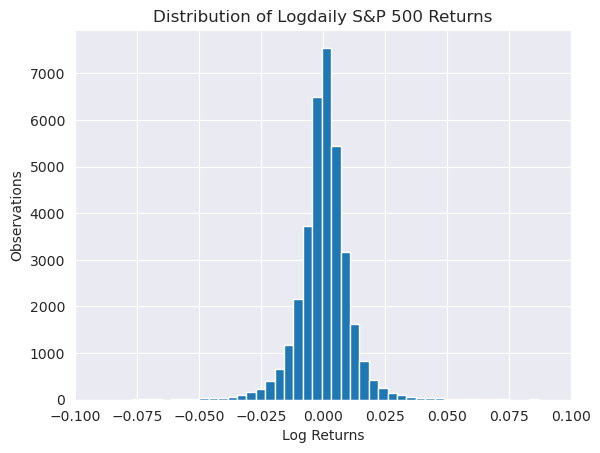

We first note that the distribution appears negatively skewed, with the
left tail being fatter than the right tail. We can verify this
empirically

In [ ]:
log_returns.skew()


``` example
np.float64(-0.43940576052749036)
```

Indeed, the distribution is negatively skewed. The value of skewness
alone gives us a hint that the data are not normally distributed.

In [ ]:
# pd.DataFrame(log_returns).boxplot()
sns.boxplot(log_returns)


``` example
<Axes: ylabel='SP500 Returns'>
```

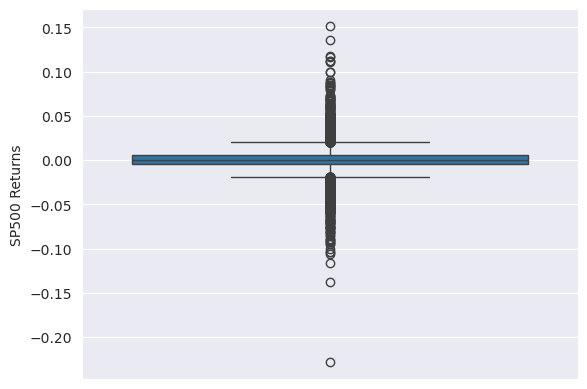

The vast majority of the log return values seem to lie in the interval
$(-0.10,0.10)$. This is the range we will inspect.

In [ ]:
clamped=pd.DataFrame(log_returns[(log_returns <= 0.1) & (log_returns >= -0.1) ])
sns.boxplot(clamped)


``` example
<Axes: >
```

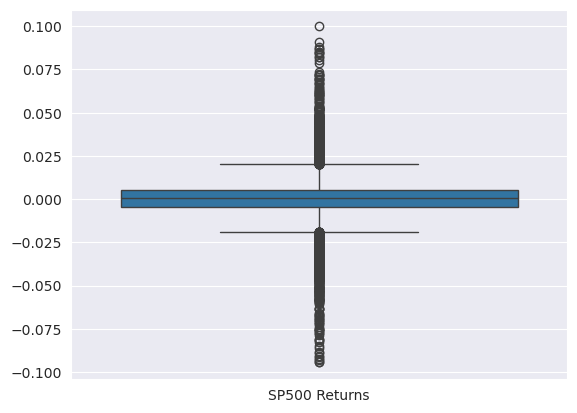

The boxplot still shows signs of negative skewness, but we can check if
the magnitude of skewness is less than what we started with.

In [ ]:
clamped.skew()


``` example
SP500 Returns   -0.330623
dtype: float64
```

The skewness does decrease in magnitude, but its value still indicates a
distribution far from normal. It seems daily returns are too negatively
skewed to recover a distribution that is normal.

# Formal Tests for Normality

So far, our tests for normality has been heuristic in nature. There are
formal tests for normality such as she Shapiro-Wilk test, which we can
employ. Below is the resulting $p$ values extracted from the test, where
the null hypothesis is that the data are normally distributed.

In [ ]:
from scipy.stats import shapiro, normaltest

names = ["Logdaily", "Logweekly","Logmonthly","Logyearly"]
vars = [log_returns,weekly_logs,monthly_logs,yearly_logs]
results = {x[0]: float(shapiro(x[1])[1]) for x in zip(names,vars)}
for res in results:
    print(f"Shapiro-Wilk {res} return p-value: {results[res]}")


``` example
Shapiro-Wilk Logdaily return p-value: 3.818543836005726e-93
Shapiro-Wilk Logweekly return p-value: 1.178035812533499e-52
Shapiro-Wilk Logmonthly return p-value: 1.2008592564652523e-28
Shapiro-Wilk Logyearly return p-value: 0.00021204832741650683
/nix/store/8f9zfpbmybfl09aq4a9nzp8a9gwgqjbf-python3.12-scipy-1.15.3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 35112.
  res = hypotest_fun_out(*samples, **kwds)
/nix/store/8f9zfpbmybfl09aq4a9nzp8a9gwgqjbf-python3.12-scipy-1.15.3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7316.
  res = hypotest_fun_out(*samples, **kwds)
```

In every performance of the Shapiro-Wilk test, the resulting $p$ value
is decidedly below $0.05$, so in every case we reject the null
hypothesis that the data are normally distributed.

On the other hand, the `normaltest` from `scipy.stats` uses skewness and
kurtosis to compare against a normal distribtution.

In [ ]:
print(f"p-values; skewness-kurtosis test:\n{normaltest(pd.concat([log_returns, weekly_logs, monthly_logs,yearly_logs],axis=1),nan_policy='omit',axis=0).pvalue}")


``` example
p-values; skewness-kurtosis test:
[0.00000000e+00 0.00000000e+00 2.01874396e-72 5.74204997e-06]
```

In this test, too, there is sufficient evidence to reject the hypothesis
that the data are normaly distributed at all sampled time scales.

We can also apply the Anderson test to each series of returns

# Testing Particular Bull Markets

We can selectively pick periods of time where volatility is lower, which
typically happens during bull markets We first examine the longest bull
market in US history: the period between December 1987 and March 2000

In [ ]:
start, end = ("1987-12-01","2000-03-01")
log_returns[start:end].plot(kind="hist",bins=50,xlabel="Log Daily Returns")


``` example
<Axes: xlabel='Log Daily Returns', ylabel='Frequency'>
```

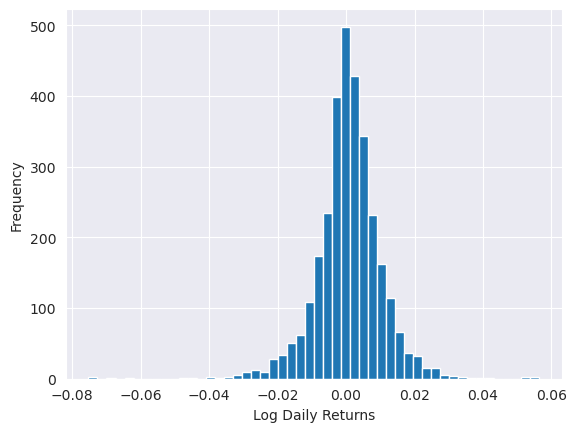

Looking at the distribution of daily returns, we can already see a
thinning of the tails, though the daily returns still appear negatively
distributed. We investigate the $p$ value of the formal Shapiro-Wilk
test on the monthly returns during this bull market.

In [ ]:
print(f"p = {normaltest(monthly_logs[start:end])[1]}")


``` example
p = 0.06689875527159461
```

With a tolerance of $p = 0.05$, there is not sufficient evidence to
reject the null hypothesis that the data is normally distributed.

We will see later why this is an impressive result. It is quite
difficult to find periods of time where the log returns show any
evidence at all of being normally distributed, and $3+13\ast 12 = 159$
logmonthly observations in this period would normally be enough to
provide evidence against normality, but this particular bull market
seems to show promise.

Let us investigate the second longest bull market spanning from March
2009 to February 2020.

In [ ]:
start, end = ("2009-03-01", "2020-02-01")
log_returns[start:end].plot(kind="hist",bins=50,xlabel="Log Daily Returns",
                            title="Log Daily Returns Mar 2009-Feb 2020")


``` example
<Axes: title={'center': 'Log Daily Returns Mar 2009-Feb 2020'}, xlabel='Log Daily Returns', ylabel='Frequency'>
```

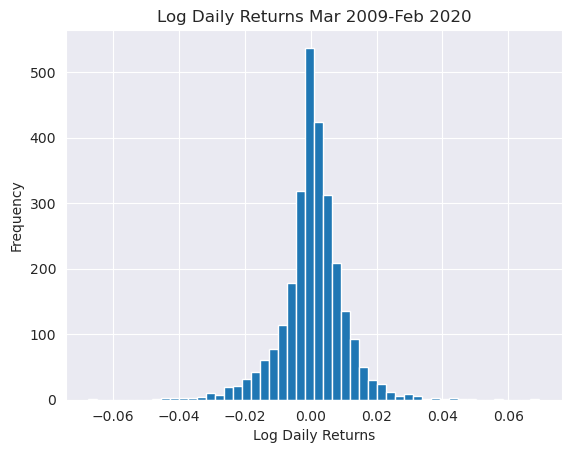

This time, the left tail is much fatter than the previous bull market
under examination.

In [ ]:
print(f"p = {normaltest(monthly_logs[start:end])[1]}")


``` example
p = 0.007993736572718346
```

This bull market instead does show signs of difference from normality.

# Individual Stocks

We should not expect it to be easy to construct a portfolio of stocks
(i.e. equities) with lognormal returns over a significant period of
time. Equities are inherently riskier than other financial assets like
bonds, and show fatter tails in distributions of historical returns on
virtually all time scales. One typically reduces the volatility of a
portfolio of stocks by allocating to "safer" kinds of stocks (e.g.
consumer staples, utilities) or by moving away from stocks altogether
and using bonds. Since we are interested in stocks only, we will work
within the confines of equities.

We hypothesize that a diverse portfolio is the wrong way to mine
logreturns that might be normal. Instead, we look at a particular
individual stock in the consumer staple sector, Coca-Cola (KO).

In [ ]:
ko = csv_to_series("./KO.csv")
log_ko = np.log(1+ko["KO Returns"])


In [ ]:
np.log(ko["KO"]).plot(title="KO Logvalue: $10000 Invested",
                      ylabel = "Logvalue")


``` example
<Axes: title={'center': 'KO Logvalue: $10000 Invested'}, xlabel='Date', ylabel='Logvalue'>
```

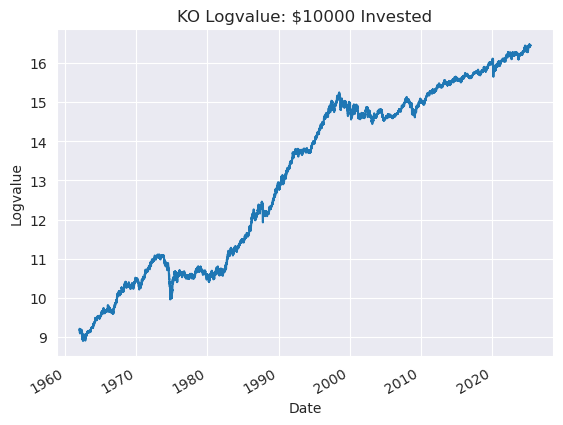

From a visual inspection of the logvalue of an investment in KO, we see
that the period between 1995 and 1996 shows promise for lognormal
returns, based on intuition alone. The reason is the log price seems to
dither around the same price, indicating a more normal random choice of
up-down movements on the day. We should want more zero-mean log returns
to have any hope of finding such a period with normally distributed
returns.

In [ ]:
s1,s2 = ("1995-04-01","1996-04-01")
from scipy.stats import probplot

probplot(log_ko[s1:s2],plot=plt)
plt.title(f"KO logdaily returns: {s1}—{s2}")
plt.show()


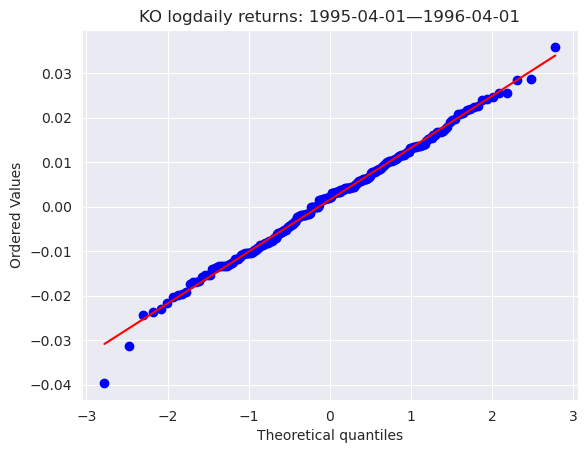

In [ ]:
log_ko[s1:s2].plot(kind="hist",bins=80)


``` example
<Axes: ylabel='Frequency'>
```

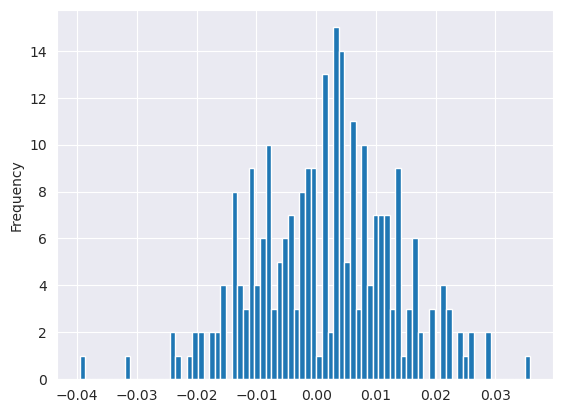

Apart from the distribution of logdaily returns looking more favorable
than our other assets, we can check the skewness and kurtosis:

In [ ]:
print(f"KO logreturns 04/1995-04/1996 p-value: {normaltest(log_ko[s1:s2])[1]}")


During the period of 04/1995 to 04/1996, we observe there is not enough
evidence to reject the null hypothesis that the data is not normally
distributed.

# Normality as a Function of Length of Time Period

In the previous section we found a yearly period where a test of
normaliy on the logdaily returns of KO did not show enough evidence to
reject the null hypothesis of normal distributivity. Here we investigate
the relationship of this $p$ value with the period of time we look over.

We will test this by testing normality of logdaily returns on the S&P
500 for rolling monthly, semiannual, yearly, 2-yearly, and 5-yearly
trading periods. In each of these rolling periods, we will test for
normality, and see in what percentage of these rolling periods we can
reject the null hypothesis.

In [ ]:
periods = [20,6*20, 252,2*252,5*252]
period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]

percent_rejected = []
for x in periods:
    rolled_ps = log_returns.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
    percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
    percent_rejected.append(percent_normal)



In [ ]:
plt.bar(x=period_names,height=percent_rejected)
plt.title("% Rejection of Normality. Rolling Periods of Logdaily S&P500 Returns")


``` example
Text(0.5, 1.0, '% Rejection of Normality. Rolling Periods of Logdaily S&P500 Returns')
```

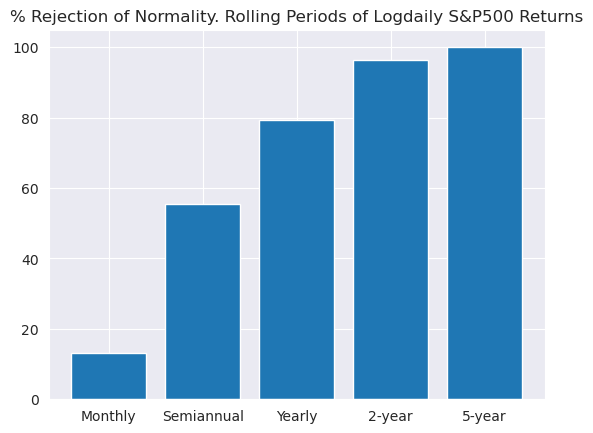

The graph gives an interpretation as follows: **given any particular
yearly period of logdaily S&P500 returns, there is a ~80% chance that
this period shows enough evidence to reject the hypothesis that the data
are normally distributed.** In other words, only 20% of rolling yearly
periods of logdaily returns show potential to be normally distributed.
Chances of finding potential for normality increase as your time window
shrinks.

We can run the same examination on KO to see how they differ, if at all.

In [ ]:
periods = [20,6*20, 252,2*252,5*252]
period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]
ko_percent_rejected = []
for x in periods:
    rolled_ps = log_ko.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
    ko_percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
    ko_percent_rejected.append(ko_percent_normal)

plt.bar(x=period_names,height=ko_percent_rejected)
plt.title("% Rejection of Normality. Rolling Periods of Logdaily KO Returns")


``` example
Text(0.5, 1.0, '% Rejection of Normality. Rolling Periods of Logdaily KO Returns')
```

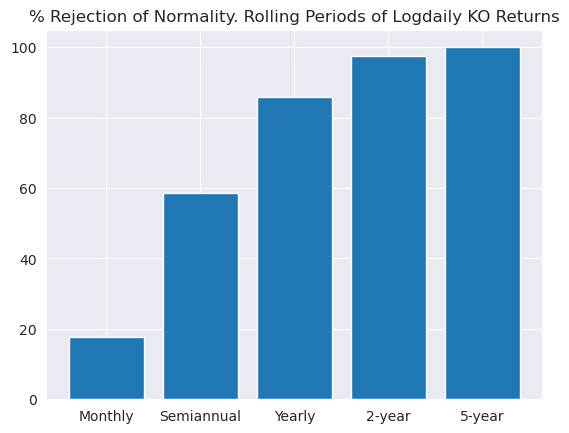

And we can run it on a few more low beta stocks/indexes to see a trend:

In [ ]:
log_gis = np.log(1+csv_to_series("./GIS.csv")["GIS Returns"]).dropna()
log_xlu = np.log(1+csv_to_series("./XLU.csv")["XLU Returns"]).dropna()
log_mcd = np.log(1+csv_to_series("./MCD.csv")["MCD Returns"]).dropna()

def reject_normality(ticker, returns):
    periods = [20,6*20, 252,2*252,5*252]
    period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]
    percent_rejected = []
    for x in periods:
        rolled_ps = returns.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
        percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
        percent_rejected.append(percent_normal)


    plt.bar(x=period_names,height=percent_rejected)
    plt.xlabel("Rolling Period")
    plt.title(f"% Rejection of Normality. Rolling Periods of Logdaily {ticker} Returns")
    plt.show()


In [ ]:
reject_normality("XLU",log_xlu)
reject_normality("GIS",log_gis)
reject_normality("MCD",log_mcd)


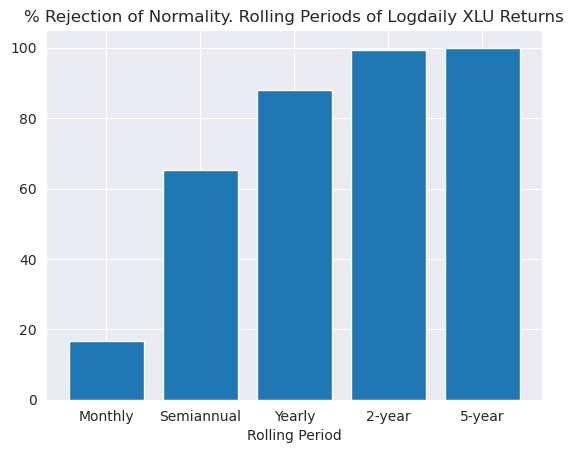
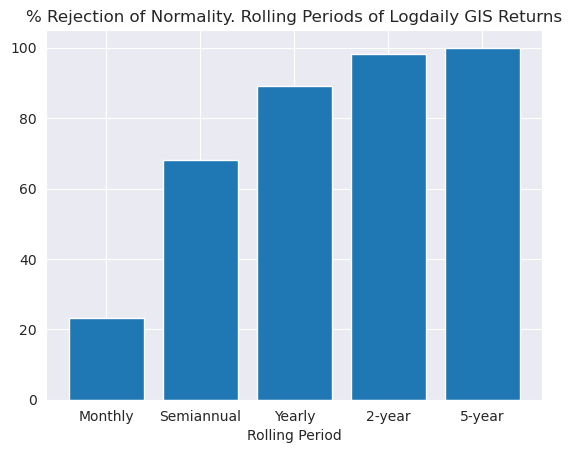
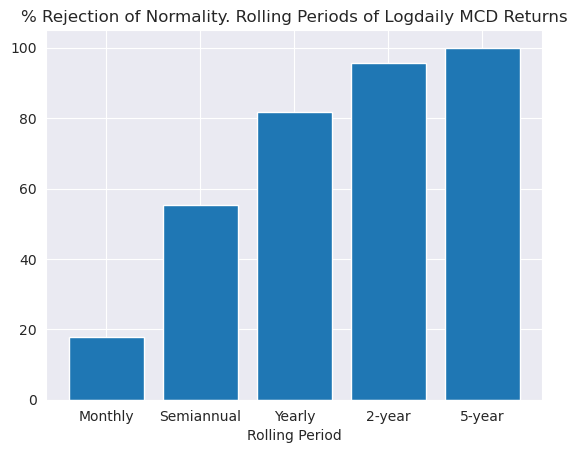

The graphs show a consistent trend that **longer periods of logdaily
returns display less liklihood of being normally distributed.** Thus,
finding periods of normally distributed returns has less to do with the
idiosyncrasies of each stock/index, and more to do with how the test
actually works. In particular, we can reasonably guess that the lack of
evidence of normality in the shorter time windows is very likely due to
the lack of data points, and not an actual statement about the intrinsic
data itself.

# Testing Project 1 Portfolio

In [ ]:
inception = "1994-12-29"
disvx = csv_to_series("../MiniProject1/DISVX-returns.csv")["DISVX Returns"]
dfsvx = csv_to_series("../MiniProject1/DFSVX-returns.csv")["DFSVX Returns"]
vti = csv_to_series("../MiniProject1/VTI-returns.csv")["VTI Returns"]
vxus = csv_to_series("../MiniProject1/VXUS-returns.csv")["VXUS Returns"]
govt = csv_to_series("../MiniProject1/GOVT-returns.csv")["GOVT Returns"]
zroz = csv_to_series("../MiniProject1/ZROZ-returns.csv")["ZROZ Returns"]
p2 = 0.28*vti[inception:] + 0.27*dfsvx[inception:] + 0.18*vxus[inception:] + 0.17*disvx[inception:] + 0.10*zroz[:inception]


In [ ]:
log_p = np.log(1+p2).dropna()
reject_normality("P1 Portfolio", log_p)


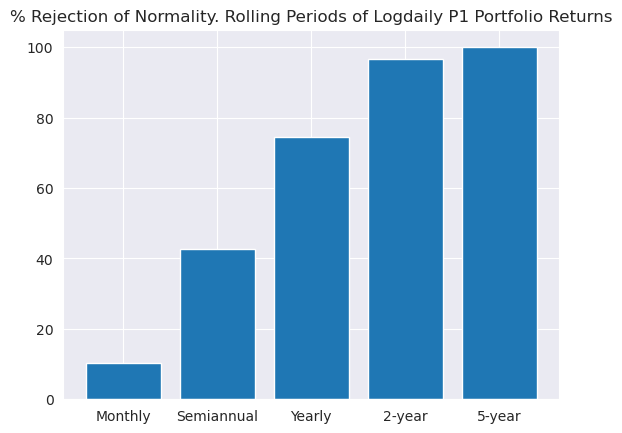

Interestingly, the high risk portfolio from my first project show more
yearly periods with promising signs of normally distributed returns,
moreso than even our most "normal" stock choice KO. The difference is
especially stark in the semiannual period, where over half the analyzed
rolling periods did not produce enough evidence to reject normality.

# Conclusion

We can conclude that finding normally distributed returns in stocks is
**essentially an exercise in arbitrary data mining**, and the pattern
fails far more often than it succeeds. Though, this is the point of this
exercise: the assumption of normal stock returns in various financial
models such as Black-Scholes is not borne out in reality, and this
illustrates that plainly. The essence of assuming lognormal returns is
simply a convenience to find closed form solutions to option prices, and
models incorporating assumptions that reflect reality are much more
difficult to work with.